-  **Dropout**

In [1]:
# Imports
import numpy as np
import tensorflow as tf

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

/Applications/anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# MNIST data
import tensorflow.examples.tutorials.mnist.input_data as data
mnist = data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Create a placeholders for input images and input image labels
n_input = mnist.train.images.shape[1]
n_output = 10
x = tf.placeholder(tf.float32, [None, n_input]) # First dim = None for mini-batch
y = tf.placeholder(tf.float32, [None, n_output])

In [4]:
# CNN requires 4D tensor: [N, H, W, C]
# Shape of x is 2D: [batch, height * width]

side = int(np.sqrt(mnist.train.images.shape[1]))

# Tensor shape "SPECIAL" value: -1 (CHECK: help(tf.reshape))
x_tensor = tf.reshape(x, [-1, side, side, 1]) # -1 makes total size constant

In [5]:
# Weight and bias initializer
def W_variable(shape):
    init = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(init)

def b_variable(shape):
    init = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(init)

**NOTE:** TensorFlow reqires image kernels/filters to be 4 dimensional (Filter Height x Filter Width x Number of Input Channels x Number of Output Channels)

In [6]:
# First convolutional layer
filter_size = 5
n_filters_1 = 32
C = 1
W_conv_1 = W_variable([filter_size, filter_size, C, n_filters_1])
b_conv_1 = b_variable([n_filters_1])

In [7]:
# Create computational graph to perform first layer of convolution
z_conv_1 = tf.add(tf.nn.conv2d(input=x_tensor, filter=W_conv_1, 
                               strides=[1, 2, 2, 1], padding='SAME'), b_conv_1)
a_conv_1 = tf.nn.relu(z_conv_1)

In [8]:
# Second convolutional layer
n_filters_2 = 16
W_conv_2 = W_variable([filter_size, filter_size, n_filters_1, n_filters_2])
b_conv_2 = b_variable([n_filters_2])

In [9]:
# Create computational graph to perform second layer of convolution
z_conv_2 = tf.add(tf.nn.conv2d(input=a_conv_1, filter=W_conv_2, 
                               strides=[1, 2, 2, 1], padding='SAME'), b_conv_2) 
a_conv_2 = tf.nn.relu(z_conv_2)

In [10]:
# Convolution layer-2 shape
print a_conv_2.get_shape()

(?, 7, 7, 16)


In [11]:
# Reshape activation output of second convolution layer to connect to a fully connected layer
a_conv_2_flat = tf.reshape(a_conv_2, [-1, 7 * 7 * n_filters_2])

In [12]:
# Create a fully connected layer
n_fc = 256
W_fc_1 = W_variable([7 * 7 * n_filters_2, n_fc])
b_fc_1 = b_variable([n_fc])
z_fc_1 = tf.add(tf.matmul(a_conv_2_flat, W_fc_1), b_fc_1)
a_fc_1 = tf.nn.relu(z_fc_1)

In [13]:
# Add dropout for regularize 
keep_prob = tf.placeholder(tf.float32)
a_fc_1_drop = tf.nn.dropout(a_fc_1, keep_prob=keep_prob)

In [14]:
# Softmax layer
W_fc_2 = W_variable([n_fc, n_output])
b_fc_2 = b_variable([n_output])
z_fc_2 = tf.add(tf.matmul(a_fc_1_drop, W_fc_2), b_fc_2)
y_pred = tf.nn.softmax(z_fc_2)

In [15]:
# Cross entropy loss and ADAM optimizer
loss = -tf.reduce_sum(y * tf.log(y_pred))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [16]:
# Accuracy
y_hat = tf.argmax(y_pred, dimension=1)
y_true = tf.argmax(y, dimension=1)
correct_pred = tf.equal(y_hat, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [17]:
# Create a session to use the graph
ses = tf.Session()

# Initialize all variables
ses.run(tf.initialize_all_variables())

In [18]:
# Train
batch_size = 100
n_epochs = 3
batches = mnist.train.num_examples//batch_size

for epoch in range(n_epochs):
    for batch in range(batches):
        batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
        ses.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
    acc = ses.run(accuracy, feed_dict={x: mnist.validation.images,
                                       y: mnist.validation.labels,
                                       keep_prob: 1.0})
    print 'Epoch-{} Validation Accuracy: {}'.format(epoch, acc)
    
print 'Test Accuracy: ', ses.run(accuracy, feed_dict={x: mnist.test.images,
                                                      y: mnist.test.labels,
                                                      keep_prob: 1.0})

Epoch-0 Validation Accuracy: 0.956799983978
Epoch-1 Validation Accuracy: 0.977800011635
Epoch-2 Validation Accuracy: 0.980000019073
Test Accuracy:  0.9789


In [19]:
# First layer filters
W = ses.run(W_conv_1)

In [22]:
# Save first layer filters
import pickle
    
with open('filters.pkl', 'wb') as output_file:
    pickle.dump(W, output_file)

In [52]:
# Function to visualize filters
def visualize_grid(X, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of filter
    Arguments:
        X: Tensor of shape (N x H x W x C)
        ubound: Output grid will have values scaled to the range [0, ubound]
        padding: The number of blank pixels between elements of the grid
    Output:
        grid
    """
    (N, H, W, C) = X.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in xrange(grid_size):
        x0, x1 = 0, W
        for x in xrange(grid_size):
            if next_idx < N:
                img = X[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

In [53]:
# Filter shape
print W.shape

(5, 5, 1, 32)


In [54]:
# Reshape Filter shape to (N x H x W x C)
W_input = W.transpose(3, 0, 1, 2)
print W_input.shape

(32, 5, 5, 1)


In [57]:
# Create filter grid
grid = visualize_grid(W_input)
print grid.shape
grid_sq = np.squeeze(grid)
print grid_sq.shape

(35, 35, 1)
(35, 35)


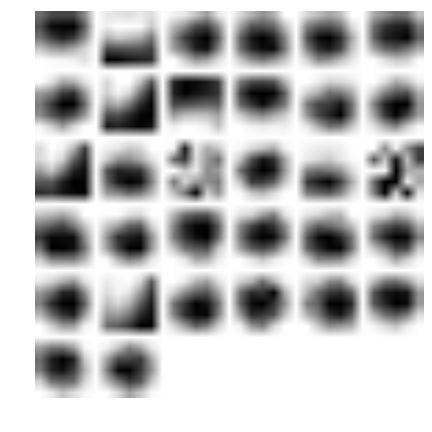

In [58]:
# Visualize first layer filters
plt.imshow(grid_sq.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

In [42]:
def montage(W):
    """Draws all filters (n_input * n_output filters) as a
    montage image separated by 1 pixel borders.

    Parameters
    ----------
    W : numpy.ndarray
        Input array to create montage of.

    Returns
    -------
    m : numpy.ndarray
        Montage image.
    """
    W = np.reshape(W, [W.shape[0], W.shape[1], 1, W.shape[2] * W.shape[3]])
    n_plots = int(np.ceil(np.sqrt(W.shape[-1])))
    m = np.ones(
        (W.shape[0] * n_plots + n_plots + 1,
         W.shape[1] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < W.shape[-1]:
                m[1 + i + i * W.shape[0]:1 + i + (i + 1) * W.shape[0],
                  1 + j + j * W.shape[1]:1 + j + (j + 1) * W.shape[1]] = (
                    np.squeeze(W[:, :, :, this_filter]))
    return m

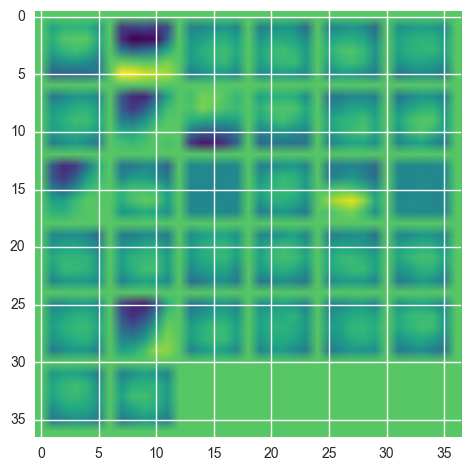

In [46]:
plt.imshow(montage(W / np.max(W)), cmap='viridis')

In [47]:
montage(W).shape

(37, 37)